# Init

In [2]:
# similarity calculation
MORGAN_RADIUS=9
FINGERPRINT_BITS=4096

# analogue selection
GROUP_SIZE=10

In [3]:
TEST_SLICE = -1  # set to -1 for full set

In [4]:
import os
import pandas as pd
import numpy as np
import numba
from numba import prange
from tqdm.notebook import tqdm

from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdFingerprintGenerator, SmilesMolSupplier

from fingerprint_computation import FingerprintGenerator, compute_fingerprints_from_smiles
from ms_chemical_space_explorer.similarity_maps import generate_mol, get_similarity_map_weights, FingerprintFunction

df_file = os.path.join("data", "explorer_group_size", f"explorer_benchmark_size{GROUP_SIZE}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")

In [5]:
import sys
import os

# Get path to the parent directory containing the package
MAIN_FOLDER = os.path.abspath(
    os.path.join(os.getcwd(), "../ms_chemical_space_explorer")
)
DATA_FOLDER = "data"
PROCESSED_DATA_FOLDER = "processed"
FILENAME = "1000_test_spectra.mgf"
FILEPATH = os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER, FILENAME)
PICKLE = "pickle"

print(f"Adding to path: {MAIN_FOLDER}")
sys.path.append(MAIN_FOLDER)

Adding to path: g:\Dokumente\Studium\MMI\Master-Arbeit\Code\ms_chemical_space_explorer


In [6]:
from rdkit import Chem
from ms_chemical_space_explorer.fragment_extractor import (
    generate_mols_from_spectrum_query,
)
import pickle
from ms_chemical_space_explorer.chemical_space_explorer import start_workflow
from tqdm.notebook import trange, tqdm
import pandas as pd

# Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

# Chemspace Explorer Initialization

In [7]:
from ms_chemical_space_explorer.chemical_space_explorer import spectra_importer

query_spectra = spectra_importer(FILEPATH)

Processing spectra: 100%|██████████| 1000/1000 [00:04<00:00, 247.22it/s]


In [8]:
def analogue_search(explorer, n: int = 2, epsilon: float = 0.2) -> pd.DataFrame:
    file = os.path.join(PICKLE, f"results_n={n}.pkl")
    try:
        with open(file, "rb") as f:
            analogues = pickle.load(f)
            print(f"Loaded analogues from {file}")

    except FileNotFoundError:
        analogues = explorer.analogue_search(query_spectra, n=n, epsilon=epsilon)

        with open(file, "wb") as f:
            pickle.dump(analogues, f)
        print(f"Analogues saved to {file}")

    return analogues

In [9]:
def generate_query_mols():
    file = os.path.join(PICKLE, f"{len(query_spectra)}_query_mols_for_{FILENAME}.pkl")
    query_mols = []
    try:
        with open(file, "rb") as f:
            query_mols = pickle.load(f)
            print(f"Loaded {len(query_mols)} query mols from {file}")

    except FileNotFoundError:
        for query_id, query_spectrum in tqdm(
            enumerate(query_spectra), desc="Generating query mols...", unit="mols"
        ):
            mol = Chem.MolFromSmiles(query_spectrum.metadata["smiles"])
            query_mols.append(mol)

        with open(file, "wb") as f:
            pickle.dump(query_mols, f)
        print(f"{len(query_mols)} query mols saved to {file}.")

    return query_mols

def generate_analogue_mols(dataFrame: pd.DataFrame, n=GROUP_SIZE):
    file = os.path.join(
        PICKLE,
        f"n={n}_analogue_dataframe_with_{len(query_spectra)*n}_mols_for_{FILENAME}.pkl",
    )
    try:
        with open(file, "rb") as f:
            dataFrame = pickle.load(f)
            print(f"Loaded dataframe with {len(dataFrame)} analogues from {file}")

    except FileNotFoundError:
        for idx, row in tqdm(
            dataFrame.iterrows(),
            desc="Adding mols to analogue dataframe...",
            unit="mols",
        ):
            mol = Chem.MolFromSmiles(row["smiles"])
            dataFrame.loc[idx, "mol"] = mol

        with open(file, "wb") as f:
            pickle.dump(dataFrame, f)
        print(f"Dataframe with {len(dataFrame)} analogue mols saved to {file}.")

    return dataFrame

In [10]:
if TEST_SLICE > 0:
    query_mols = generate_query_mols()[:TEST_SLICE]
else:
    query_mols = generate_query_mols()

Loaded 603 query mols from pickle\603_query_mols_for_1000_test_spectra.mgf.pkl


In [11]:
# sanity check
if TEST_SLICE > 0:
    assert len(query_mols[:TEST_SLICE]) == len(query_spectra[:TEST_SLICE])
else:
    assert len(query_mols) == len(query_spectra)

len(query_spectra) * GROUP_SIZE

6030

#### helper functions

In [12]:
def sanitize_filename(filename):
    """Replace invalid filename characters with underscores."""
    # Characters not allowed in Windows filenames
    invalid_chars = r'<>:"/\|?*(),'
    for char in invalid_chars:
        filename = filename.replace(char, "___")
    return filename

In [13]:
def get_query_analogues(query_id: int, analogues_df: pd.DataFrame) -> list:
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["mol"].tolist()

def get_query_analogues_smiles(query_id: int, analogues_df: pd.DataFrame) -> list:
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["smiles"].tolist()

def get_query_analogues_isf(query_id: int, analogues_df: pd.DataFrame) -> list:
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["isf"].tolist()

def get_query_analogues_distance(query_id: int, analogues_df: pd.DataFrame) -> list:
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["predicted_distance"].tolist()

In [14]:
explorer = start_workflow(os.path.abspath(os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER)))

Initialize ChemExplorer


d:\Programmierung\anaconda3\envs\chemspace\Lib\site-packages\ms2deepscore\models\load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(

In [15]:
n = 2

n_analogues = analogue_search(explorer=explorer, n=n)
n_analogues = generate_analogue_mols(n_analogues, n=n)
n_analogues.head()

Loaded analogues from pickle\results_n=2.pkl
Loaded dataframe with 1205 analogues from pickle\n=2_analogue_dataframe_with_1206_mols_for_1000_test_spectra.mgf.pkl


,smiles,predicted_distance,mean_distance,std_distance,isf,candidate_mean_similarity,candidate_std_similarity,precursor_mz_diff,visual_x,visual_y,inchikey,query_spectrum_id,ionmode,mol
989,CCCCC\C=C/C\C=C/CCCCCCCC(=O)OCC(COP(O)(=O)OC1C...,0.037059,0.039914,0.005182,0.966980,0.951327,0.039300,-4.033600,10.855725,2.893498,IDBHHLONPONREV,176,negative,<rdkit.Chem.rdchem.Mol object at 0x0000017D661...
990,CCCCCCCCCCCCCCCCC(=O)OCC(COP(O)(=O)OC1C(O)C(O)...,0.039129,0.039914,0.005182,0.966980,0.951327,0.039300,-14.021600,6.573919,3.105054,NHCUHDJVBAQLLF,176,negative,<rdkit.Chem.rdchem.Mol object at 0x0000017D661...
1128,CCCCC\C=C/C\C=C/CCCCCCCC(=O)OCC(COP(O)(=O)OC1C...,0.039124,0.036931,0.004866,0.964284,0.947459,0.039397,-6.041800,12.741820,0.653669,PJGBJPJEYMOHKG,245,negative,<rdkit.Chem.rdchem.Mol object at 0x0000017D6C6...
1127,[H][C@@](COC(=O)CCCCCCCCCCCCCCCCC)(COP(O)(=O)O...,0.038959,0.036931,0.004866,0.964284,0.947459,0.039397,2.014000,14.301462,-4.717507,BSTMJEKBGMABBW,245,negative,<rdkit.Chem.rdchem.Mol object at 0x0000017D6C6...
1177,O=c1c(O[C@@H]2O[C@H](CO[C@@H]3OC[C@@H](O)[C@H]...,0.011304,0.036587,0.018995,0.960712,0.941694,0.052139,-14.015676,13.708264,3.044262,YNMFDPCLPIMRFD,270,negative,<rdkit.Chem.rdchem.Mol object at 0x0000017D6C6...


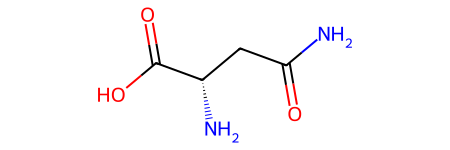

In [16]:
query_id = 8
query_mols[query_id]

In [17]:
analogue_id = 0
get_query_analogues_smiles(query_id=query_id, analogues_df=n_analogues)

['CC(=O)N1CCC[C@H]1C(=O)O', 'NCC(=O)N(C1)C(CC1)C(O)=O']

# Benchmark

In [18]:
# code taken from https://github.com/florian-huber/molecular_fingerprint_comparisons
@numba.njit
def ruzicka_similarity(A, B):
    """
    Calculate the Ruzicka similarity between two count vectors.
    
    Parameters:
    A (array-like): First count vector.
    B (array-like): Second count vector.
    
    Returns:
    float: Ruzicka similarity.
    """
    
    min_sum = np.sum(np.minimum(A, B))
    max_sum = np.sum(np.maximum(A, B))
    
    return min_sum / max_sum


@numba.jit(nopython=True, fastmath=True, parallel=True)
def ruzicka_similarity_matrix(references: np.ndarray, queries: np.ndarray) -> np.ndarray:
    """Returns matrix of Ruzicka similarity between all-vs-all vectors of references and queries.

    Parameters
    ----------
    references
        Reference vectors as 2D numpy array. Expects that vector_i corresponds to
        references[i, :].
    queries
        Query vectors as 2D numpy array. Expects that vector_i corresponds to
        queries[i, :].

    Returns
    -------
    scores
        Matrix of all-vs-all similarity scores. scores[i, j] will contain the score
        between the vectors references[i, :] and queries[j, :].
    """
    assert references.shape[1] == queries.shape[1], f"Vector sizes do not match! {references.shape[1]} != {queries.shape[1]}"

    size1 = references.shape[0]
    size2 = queries.shape[0]
    scores = np.zeros((size1, size2)) #, dtype=np.float32)
    for i in prange(size1):
        for j in range(size2):
            scores[i, j] = ruzicka_similarity(references[i, :], queries[j, :])
    return scores

In [19]:
def numpy_2_fp(array):
    # taken from https://stackoverflow.com/questions/54809506/how-can-i-compute-a-count-morgan-fingerprint-as-numpy-array
    fp = DataStructs.cDataStructs.IntSparseIntVect(len(array))
    for ix, value in enumerate(array):
        fp[ix] = int(value)
    return fp

query_id = 564  # somehow only one analogue is returned for this query
analogue_ids = n_analogues[n_analogues["query_spectrum_id"] == query_id].index.tolist()

fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=FINGERPRINT_BITS)
query = query_mols[query_id]

query_fp = np.zeros((0,), dtype=np.int8)
DataStructs.ConvertToNumpyArray(fpgen.GetCountFingerprint(query), query_fp)

analogue_fps = np.zeros((len(analogue_ids), FINGERPRINT_BITS), dtype=np.int8)
for i, analogue in enumerate(n_analogues.loc[analogue_ids].mol):
    analogue_fp_rdkit = fpgen.GetCountFingerprint(analogue)
    DataStructs.ConvertToNumpyArray(analogue_fp_rdkit, analogue_fps[i])

query_sims = [ruzicka_similarity(query_fp, analogue_fp) for analogue_fp in analogue_fps]
fp_group_sim_matrix = ruzicka_similarity_matrix(analogue_fps, analogue_fps)
group_sim = off_diagonal_mean(fp_group_sim_matrix)
print(query_id)
analogue_ids

In [20]:
def get_fingerprint(inchikey, key_error_fps, fpgen, mol):
    """Get the fingerprint for a given inchikey, using a cache for key errors."""
    if inchikey in explorer.fingerprints.index:
        fp = explorer.fingerprints.loc[inchikey].values
    elif inchikey in key_error_fps:
        fp = key_error_fps[inchikey]
    else:
        print(f"{inchikey} not found. Adding to key error fingerprints...")
        fp = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fpgen.GetCountFingerprint(mol), fp)
        key_error_fps[inchikey] = fp
    return fp

query_id = 11
key_error_fps = {}
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=MORGAN_RADIUS, fpSize=FINGERPRINT_BITS)
analogue_ids = n_analogues[n_analogues["query_spectrum_id"] == query_id].index.tolist()

query_inchikey = query_spectra[query_id].metadata["inchikey"][:14]
query_fp = get_fingerprint(query_inchikey, key_error_fps, fpgen, query_mols[query_id])

analogue_fps = [get_fingerprint(row.inchikey, key_error_fps, fpgen, row.mol) for row in n_analogues.loc[analogue_ids].itertuples()]
analogue_fps = np.array(analogue_fps)
analogue_fps

DUNAUAIIHKOMFG not found. Adding to key error fingerprints...


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [21]:
columns = [
    "query_sim", "query_mean_weights", "group_sim", "sgs", "sgs_score", "isf_score", "distance",
    "query_sims","sgs_scores", "isf_scores", "distances",
    "query_smiles", "group_smiles", 
    ]

In [22]:
def off_diagonal_mean(matrix):
    n = matrix.shape[0]
    # Create mask for off-diagonal elements
    mask = ~np.eye(n, dtype=bool)
    return matrix[mask].mean()

def str_to_list_of_ints(series):
    return [int(x) for x in series.strip("[]").split(",") if x.strip().isdigit()]

def get_group_sized_benchmark_df_file(df_file, query_mols, n_analogues, morgan_radius, fpSize, group_size, key_error_fps):
    try:
        analogue_df = pd.read_csv(df_file, index_col=0)
        #analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)
        print(f"Found {df_file}\nTrying to access benchmark columns.\nExisting columns: {analogue_df.columns.tolist()}")
        query_smiles= analogue_df[:1].query_smiles
        query_sim= analogue_df[:1].query_sim
        query_sims=analogue_df[:1].query_sims
        query_mean_weights=analogue_df[:1].query_mean_weights
        group_smiles=analogue_df[:1].group_smiles
        group_sim=analogue_df[:1].group_sim
        sgs=analogue_df[:1].sgs
        sgs_score=analogue_df[:1].sgs_score
        sgs_scores=analogue_df[:1].sgs_scores
        isf_score=analogue_df[:1].isf_score
        isf_scores=analogue_df[:1].isf_scores
        distance=analogue_df[:1].distance
        distances=analogue_df[:1].distances
        print(f"Benchmark found! Loaded benchmark for {len(analogue_df)} queries.")
    except Exception as e:
        print(f"Benchmark not found: {df_file}\nRunning the benchmark dataframe generation.")
        # generate benchmark dataframe with len(query_mols) rows
        analogue_df = pd.DataFrame(index=range(len(query_mols)),
                                   dtype=object,
                                   columns=columns)
              
        simmap_fp_function = FingerprintFunction(fingerprint="MORGAN")
        simmap_fp_function.fp_type = "count"
        simmap_fp_function.morgan_radius = morgan_radius
        simmap_fp_function.nbits = fpSize
        fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=morgan_radius, fpSize=fpSize)
        
        n_analogues = analogue_search(explorer=explorer, n=group_size)
        n_analogues = generate_analogue_mols(n_analogues, n=group_size)

        for query_id, query in tqdm(enumerate(query_mols), desc="Processing queries", leave=False, total=len(query_mols)):
            analogue_ids = n_analogues[n_analogues["query_spectrum_id"] == query_id].index.tolist()
            if len(analogue_ids) < 2:
                print(f"Skipping query {query_id} with less than 2 analogues.")
                continue
            
            try:
                query_inchikey = query_spectra[query_id].metadata["inchikey"][:14]
                query_fp = get_fingerprint(query_inchikey, key_error_fps, fpgen, query_mols[query_id])
                
                analogue_fps = [get_fingerprint(row.inchikey, key_error_fps, fpgen, row.mol) for row in n_analogues.loc[analogue_ids].itertuples()]
                analogue_fps = np.array(analogue_fps)
            except KeyError as e:
                print(f"KeyError: {e}. Calculating fingerprints for query {query_id} and analogues.")
                query_fp = np.zeros((0,), dtype=np.int8)
                DataStructs.ConvertToNumpyArray(fpgen.GetCountFingerprint(query), query_fp)
                key_error_smiles = explorer.reference_compounds.loc[e].smiles
                key_error_fp = np.zeros((0,), dtype=np.int8)
                DataStructs.ConvertToNumpyArray(fpgen.GetCountFingerprint(Chem.MolFromSmiles[key_error_smiles]), key_error_fp)
                key_error_fps[e] = key_error_fp

                analogue_fps = np.zeros((len(analogue_ids), FINGERPRINT_BITS), dtype=np.int8)
                for i, analogue in enumerate(n_analogues.loc[analogue_ids].mol):
                    DataStructs.ConvertToNumpyArray(fpgen.GetCountFingerprint(analogue), analogue_fps[i])

            query_sims = [ruzicka_similarity(query_fp, analogue_fp) for analogue_fp in analogue_fps]
            
            stacked_mean_weights = []
            query_mean_weights = []
            query_scaled_inverted_differnces = []
            for ref_id in analogue_ids:
                ref_analogue = n_analogues.loc[ref_id, "mol"]
                
                # create array for stacked weights
                stacked_atomic_weights = [0] * ref_analogue.GetNumAtoms()
                
                # compute the group similarity map weights
                for probe_id in analogue_ids:#tqdm(analogue_ids, desc=f"Computing weights for weights for analogue {ref_id}", leave=False):
                    if ref_id == probe_id:
                        continue
                    
                    probe_analogue = n_analogues.loc[probe_id, "mol"]

                    # extract and standardize similarity weights for the reference molecule
                    ref_sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(probe_analogue, ref_analogue, simmap_fp_function.get_function, metric=DataStructs.TanimotoSimilarity) #this is the bottle neck
                    #print(f"Getting weights took {(pd.Timestamp.now() - getting_weights_start).total_seconds():.4f} seconds")

                    # stack the weights
                    stacked_atomic_weights = [stacked_atomic_weights[i] + ref_sim_weights[i] for i in range(ref_analogue.GetNumAtoms())]
                # Standardize the stacked weights
                stacked_atomic_weights, _ = SimilarityMaps.GetStandardizedWeights(stacked_atomic_weights)
                stacked_mean_weights.append(sum(stacked_atomic_weights) / len(stacked_atomic_weights))
                
                # compute the similarity map weights against the query molecule
                query_atomic_weights = get_similarity_map_weights(ref_analogue, query, simmap_fp_function)
                query_mean_weights.append(sum(query_atomic_weights) / len(query_atomic_weights))
                
                # calculate absolute weight difference for each atom against the query
                query_abs_differences = ([abs(stacked_atomic_weights[i] - query_atomic_weights[i]) for i in range(len(stacked_atomic_weights))])
                query_mean_difference = sum(query_abs_differences) / len(query_abs_differences)
                
                # scale and invert the mean absolute difference to get a similarity score
                query_scaled_inverted_differnce = 1 - (query_mean_difference * 0.5)
                query_scaled_inverted_differnces.append(query_scaled_inverted_differnce)
            
            # --- gather results ---
            
            # smiles
            analogue_df.at[query_id, "group_smiles"] = get_query_analogues_smiles(query_id=query_id, analogues_df=n_analogues)
            analogue_df.loc[query_id, "query_smiles"] = query_spectra[query_id].metadata["smiles"]
            
            # all query sims
            analogue_df.at[query_id, "query_sims"] = query_sims
            # mean ruzicka similarity of analogue vs query ruzicka similaities
            analogue_df.loc[query_id, "query_sim"] = np.mean(query_sims)
            
            #  mean of the means of query atomic weights
            unscaled_query_mean_weights = np.mean(query_mean_weights)  # range [-1, 1]
            analogue_df.loc[query_id, "query_mean_weights"] = (unscaled_query_mean_weights + 1) / 2   # range [0, 1]
            
            # mean of all-vs-all analogue ruzicka similarities
            fp_group_sim_matrix = ruzicka_similarity_matrix(analogue_fps, analogue_fps)
            group_sim = off_diagonal_mean(fp_group_sim_matrix)
            analogue_df.loc[query_id, "group_sim"] = group_sim
            
            # mean of the means of stacked atomic weights of all-vs-all analogue similarity maps
            unscaled_sgs = np.mean(stacked_mean_weights)                # range [-1, 1]
            analogue_df.loc[query_id, "sgs"] = (unscaled_sgs + 1) / 2   # range [0, 1]
            
            # all SQS
            analogue_df.loc[query_id, "sgs_scores"] = query_scaled_inverted_differnces
            # scaled and inverted mean of the means of the absolute differences between atomic stacked weights and atomic query weights
            sgs_score = (sum(query_scaled_inverted_differnces) / len(query_scaled_inverted_differnces))
            analogue_df.loc[query_id, "sgs_score"] = sgs_score
            
            # ISF
            isf_scores = get_query_analogues_isf(query_id=query_id, analogues_df=n_analogues)
            analogue_df.at[query_id, "isf_scores"] = isf_scores
            analogue_df.loc[query_id, "isf_score"] = np.mean(isf_scores)
            
            # distance
            distances = get_query_analogues_distance(query_id=query_id, analogues_df=n_analogues)
            analogue_df.loc[query_id, "distances"] = distances
            analogue_df.loc[query_id, "distance"] = np.mean(distances)

        analogue_df.infer_objects()
        analogue_df.to_csv(df_file)
        print(f"Saved {len(analogue_df)} queries to {df_file}.")
    return analogue_df

In [23]:
try:
    key_error_fps = pickle.load(open(os.path.join("data", "explorer_group_size", "key_error_fps.pkl"), "rb"))
    print(f"Loaded {len(key_error_fps)} key error fingerprints.")
except FileNotFoundError:
    key_error_fps = {}
    print("No key error fingerprints found. Starting with an empty dictionary.")

Loaded 370 key error fingerprints.


In [24]:
max_group_size = GROUP_SIZE + 1
all_dfs = []

for group_size in tqdm(range(2, max_group_size), desc="Benchmarking varying group sizes..."):
    group_sized_df_file = os.path.join("data", "explorer_group_size", f"explorer_benchmark_size{group_size}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")
    analogue_df = get_group_sized_benchmark_df_file(group_sized_df_file, query_mols, n_analogues, MORGAN_RADIUS, FINGERPRINT_BITS, group_size, key_error_fps)
    analogue_df["group_sim_diff"] = abs(analogue_df.sgs - analogue_df.group_sim)
    print(f"-------- Group size {group_size}: Entries with group_sim_diff greater than 0.05 = {len(analogue_df[analogue_df.group_sim_diff > 0.05])} --------")
    all_dfs.append(analogue_df)

Benchmarking varying group sizes...:   0%|          | 0/9 [00:00<?, ?it/s]

Found data\explorer_group_size\explorer_benchmark_size2_morgan9_4096bits.csv
Trying to access benchmark columns.
Existing columns: ['query_sim', 'query_mean_weights', 'group_sim', 'sgs', 'sgs_score', 'isf_score', 'distance', 'query_sims', 'sgs_scores', 'isf_scores', 'distances', 'query_smiles', 'group_smiles']
Benchmark found! Loaded benchmark for 603 queries.
-------- Group size 2: Entries with group_sim_diff greater than 0.05 = 524 --------
Found data\explorer_group_size\explorer_benchmark_size3_morgan9_4096bits.csv
Trying to access benchmark columns.
Existing columns: ['query_sim', 'query_mean_weights', 'group_sim', 'sgs', 'sgs_score', 'isf_score', 'distance', 'query_sims', 'sgs_scores', 'isf_scores', 'distances', 'query_smiles', 'group_smiles']
Benchmark found! Loaded benchmark for 603 queries.
-------- Group size 3: Entries with group_sim_diff greater than 0.05 = 476 --------
Found data\explorer_group_size\explorer_benchmark_size4_morgan9_4096bits.csv
Trying to access benchmark co

In [25]:
all_dfs[0].infer_objects().describe()

,query_sim,query_mean_weights,group_sim,sgs,sgs_score,isf_score,distance,group_sim_diff
count,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000
mean,0.359101,0.335631,0.687371,0.476269,0.754254,0.418305,0.169333,0.239992
std,0.278634,0.138733,0.271699,0.176936,0.144206,0.170417,0.069904,0.160298
min,0.000000,0.140381,0.011628,0.176668,0.343649,0.098914,0.004048,0.000045
25%,0.150144,0.236550,0.460649,0.314126,0.646223,0.292482,0.116566,0.097946
50%,0.246704,0.285849,0.767537,0.458934,0.784911,0.376930,0.172137,0.225875
75%,0.526076,0.397905,0.930476,0.647872,0.876572,0.500764,0.219523,0.354464
max,1.000000,0.789490,1.000000,0.868962,0.997001,0.966980,0.359433,0.685337


# Results

In [26]:
columns[7:11]

['query_sims', 'sgs_scores', 'isf_scores', 'distances']

In [27]:
columns[:6]

['query_sim',
 'query_mean_weights',
 'group_sim',
 'sgs',
 'sgs_score',
 'isf_score']

In [28]:
columns[11:]

['query_smiles', 'group_smiles']

In [29]:
all_dfs[0][columns[:7]].mean()

query_sim             0.359101
query_mean_weights    0.335631
group_sim             0.687371
sgs                   0.476269
sgs_score             0.754254
isf_score             0.418305
distance              0.169333
dtype: float64

In [30]:
benchmark_columns = columns[:6]
benchmark_df = pd.DataFrame(columns=benchmark_columns, index=pd.Index([], name='n'))

for i, df in enumerate(all_dfs):
    n = i + 2
    benchmark_df.loc[n, benchmark_columns] = df[benchmark_columns].mean()

In [31]:
benchmark_df

,query_sim,query_mean_weights,group_sim,sgs,sgs_score,isf_score
n,,,,,,
2,0.359101,0.335631,0.687371,0.476269,0.754254,0.418305
3,0.351089,0.332656,0.589273,0.443598,0.783876,0.412784
4,0.341119,0.329039,0.520166,0.413346,0.806357,0.405933
5,0.33275,0.326414,0.464631,0.389231,0.822893,0.397957
6,0.32449,0.323944,0.421645,0.371668,0.834658,0.389393
7,0.315138,0.320335,0.383826,0.356615,0.845605,0.379825
8,0.303044,0.317628,0.348109,0.344998,0.853594,0.36834
9,0.288095,0.314629,0.310791,0.335035,0.858688,0.352937
10,0.271683,0.313382,0.273916,0.330557,0.861851,0.333411


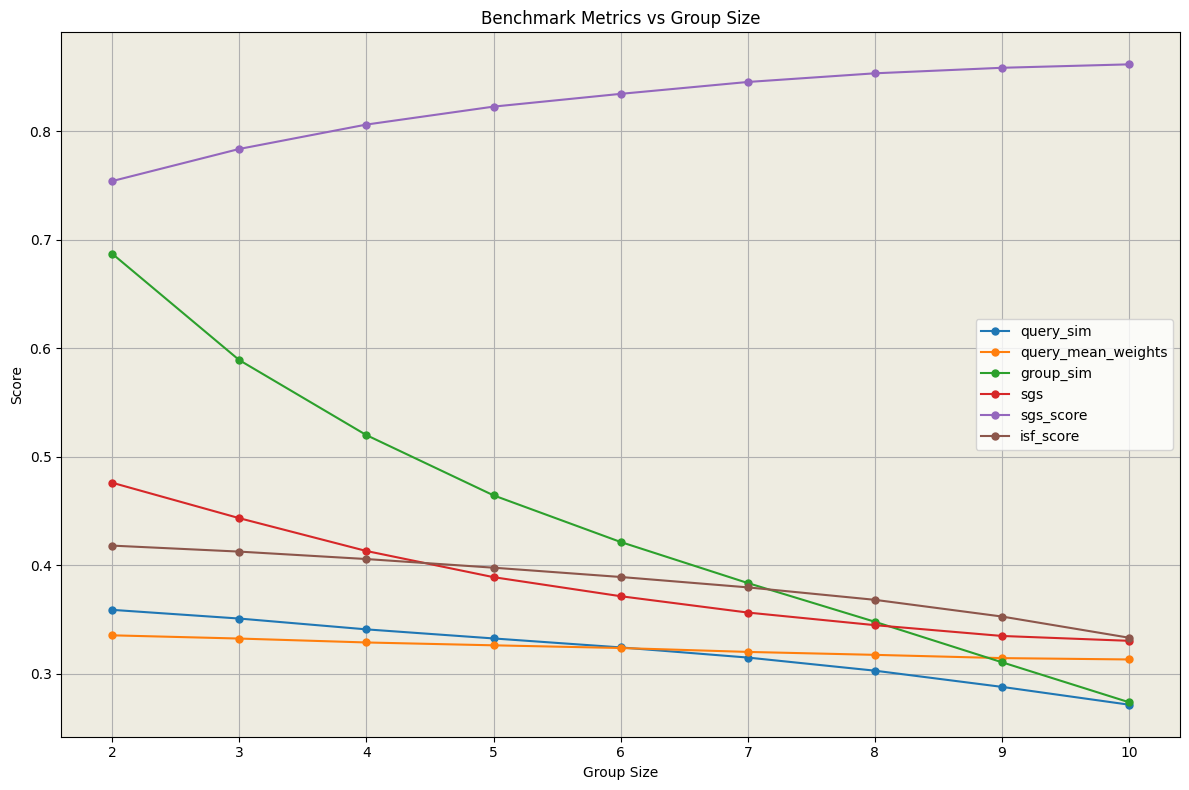

In [36]:
import matplotlib.pyplot as plt

# Create a single plot with all metrics
fig, ax = plt.subplots(figsize=(12, 8))

x = benchmark_df.index

# Plot all columns as separate lines on the same plot
for column in benchmark_columns:
    y = benchmark_df[column]
    ax.plot(x, y, label=column, marker='o', markersize=5)

ax.set_facecolor("#EEECE1")
ax.set_xlabel("Group Size")
ax.set_ylabel("Score")
ax.set_title("Benchmark Metrics vs Group Size")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

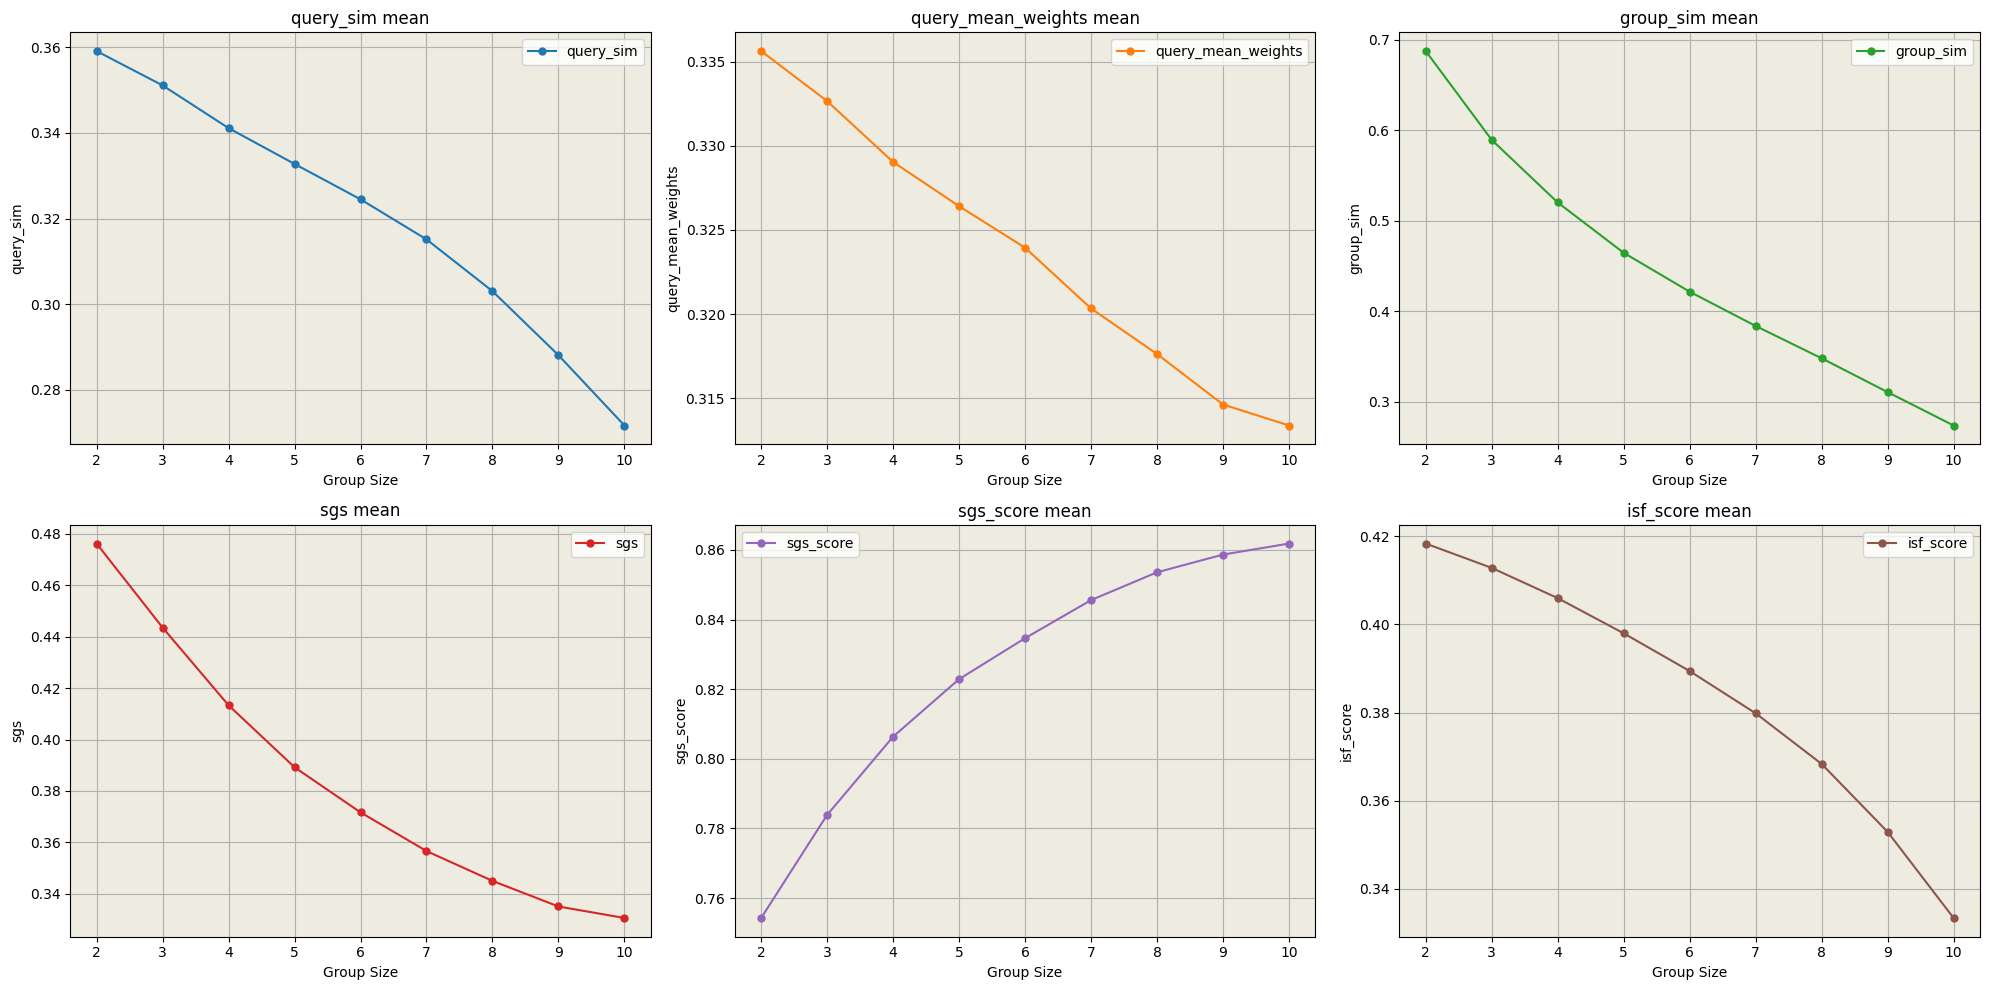

In [37]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2 rows, 4 columns for 7 plots + 1 empty
axes = axes.flatten()  # Flatten to make indexing easier

x = benchmark_df.index

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, column in enumerate(benchmark_columns):
    ax = axes[i]
    y = benchmark_df[column]
    
    # Plot lines with different markers
    color = colors[i % len(colors)]
    ax.plot(x, y, label=f"{column}", marker='o', markersize=5, color=color)
    ax.set_facecolor("#EEECE1")
    
    ax.set_xlabel("Group Size")
    ax.set_ylabel(column)
    ax.grid(True)
    ax.set_title(f"{column} mean")
    ax.legend()

# Hide the last empty subplot
#axes[7].set_visible(False)

plt.tight_layout()
plt.show()

In [38]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Create a figure with subplots for animation
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Calculate global min/max for each column across all dataframes
global_x_ranges = {}
for column in benchmark_columns:
    all_values = []
    for df in all_dfs:
        all_values.extend(df[column].dropna().values)
    
    if all_values:
        global_x_ranges[column] = {
            'min': min(all_values),
            'max': max(all_values)
        }
    else:
        global_x_ranges[column] = {'min': 0, 'max': 1}

# Calculate global y-axis max for histogram counts
global_y_max = 25
bins = 150
global_y_maxes = {}
for column in benchmark_columns:
    column_max = 0
    for df in all_dfs:
        data = df[column].dropna()
        if len(data) > 0:
            counts, _ = np.histogram(data, bins=bins)
            column_max = max(column_max, max(counts))
    
    global_y_maxes[column] = column_max if column_max > 0 else 25

def animate(frame):
    # Clear all subplots
    for ax in axes:
        ax.clear()
    
    # Get the current dataframe
    df = all_dfs[frame]
    group_size = frame + 2
    
    # Set the main title
    fig.suptitle(f"Group Size {group_size} Benchmark Metrics", fontsize=16)
    
    # Plot each metric
    for i, column in enumerate(benchmark_columns):
        ax = axes[i]
        
        # Use consistent colors
        color = colors[i % len(colors)]
        
        # Get data and filter NaN values
        data = df[column].dropna()
        
        if len(data) > 0:
            ax.hist(data, bins=bins, alpha=0.7, label=f"{column}", color=color)
        
        ax.set_facecolor("#EEECE1")
        # Set consistent axis limits
        ax.set_xlim(global_x_ranges[column]['min'], global_x_ranges[column]['max'])
        ax.set_ylim(0, global_y_maxes[column] * 1.05)  # Add 5% padding
        
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")
        ax.grid(True)
        ax.set_title(f"{column} distribution")
        ax.legend()
    
    plt.tight_layout()

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=len(all_dfs), interval=1000, repeat=True)
plt.close(fig)  # Close the figure to avoid displaying it twice in Jupyter

# Optionally save as GIF
anim.save('benchmark_metrics_animation.gif', writer='pillow', fps=1.2)

# Display the animation
HTML(anim.to_jshtml())

C:\Users\kevin\AppData\Local\Temp\ipykernel_11664\3153476817.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\kevin\AppData\Local\Temp\ipykernel_11664\3153476817.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

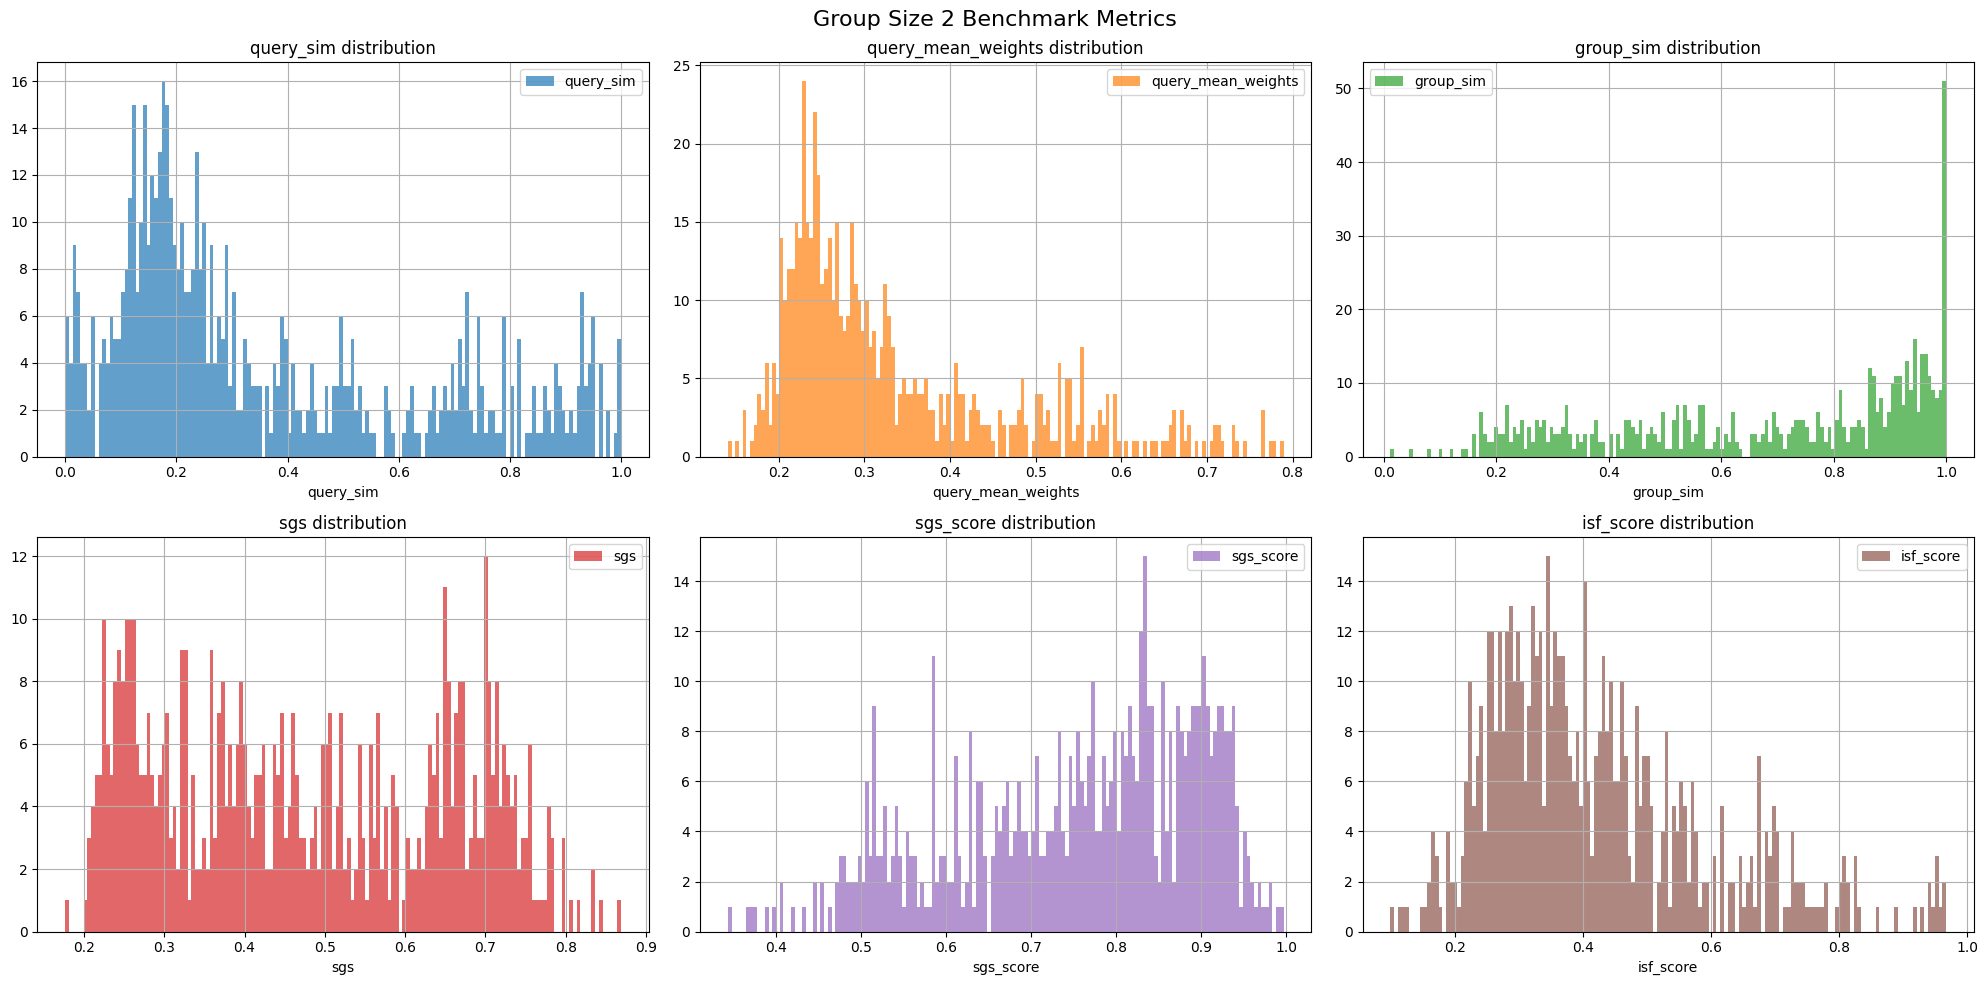

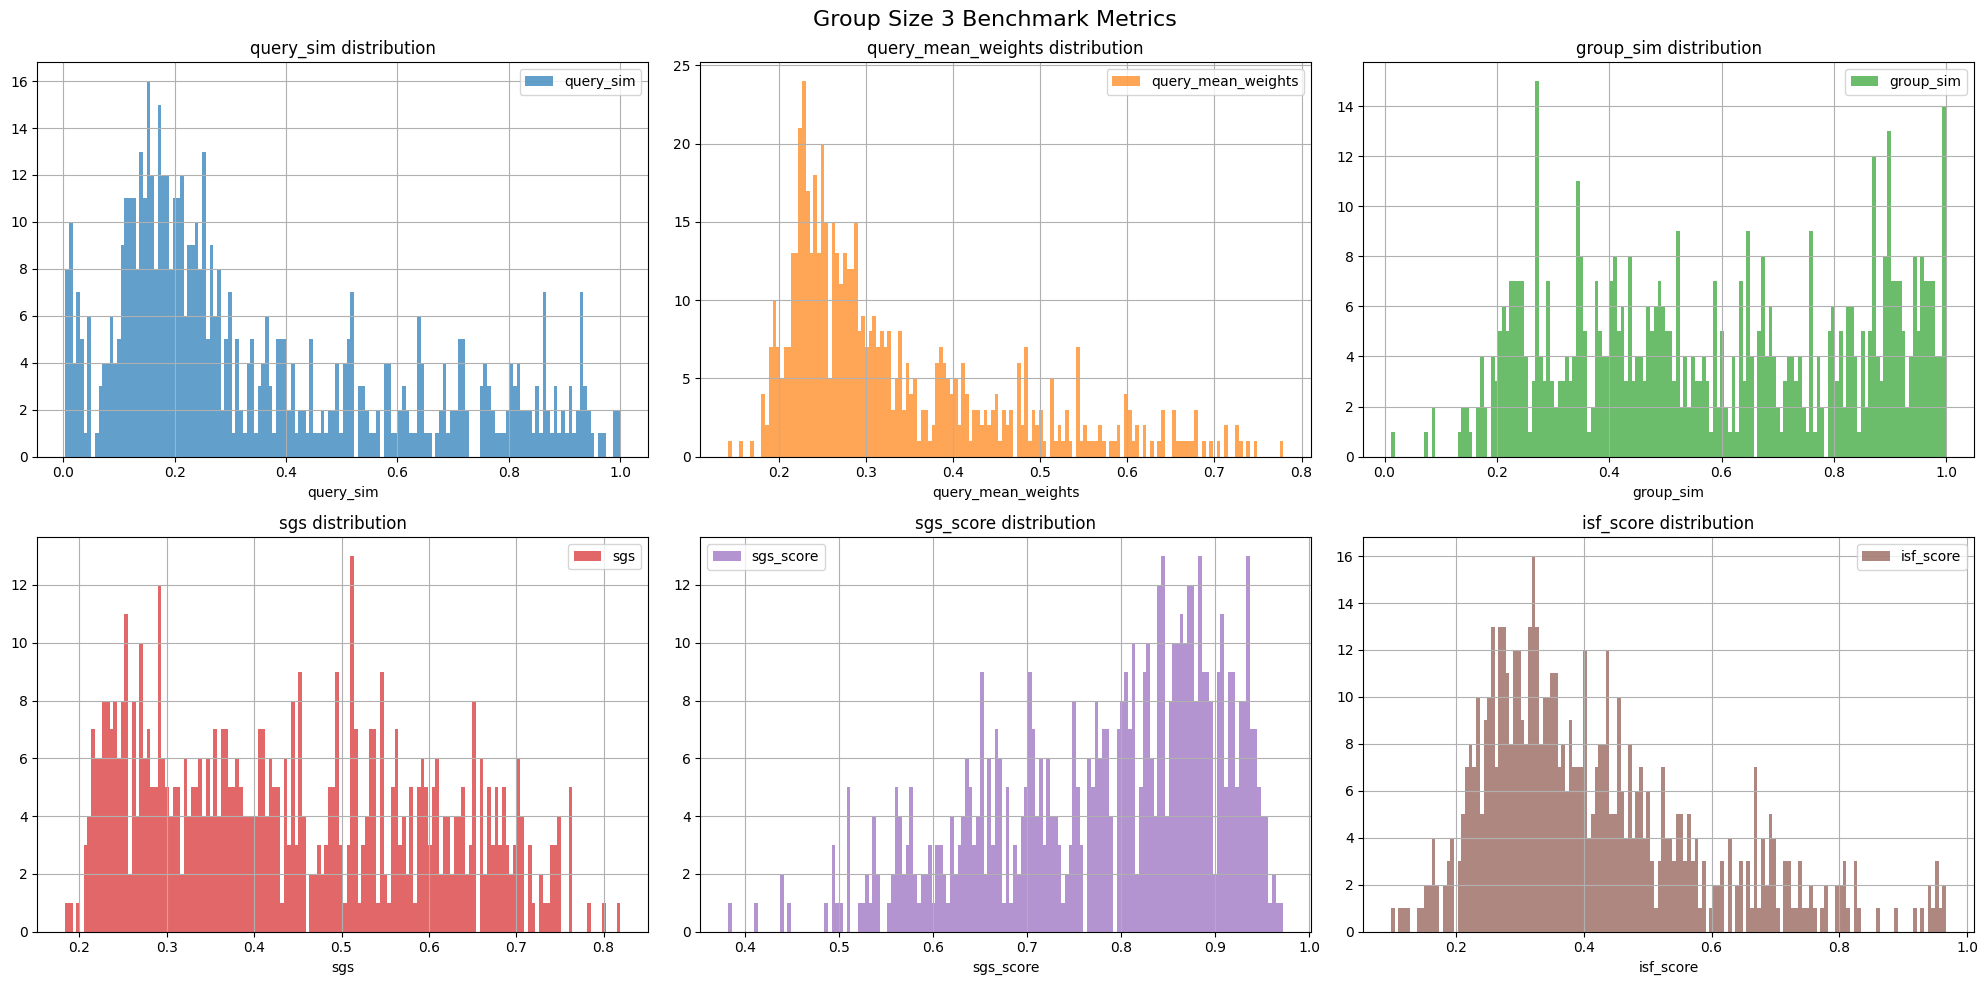

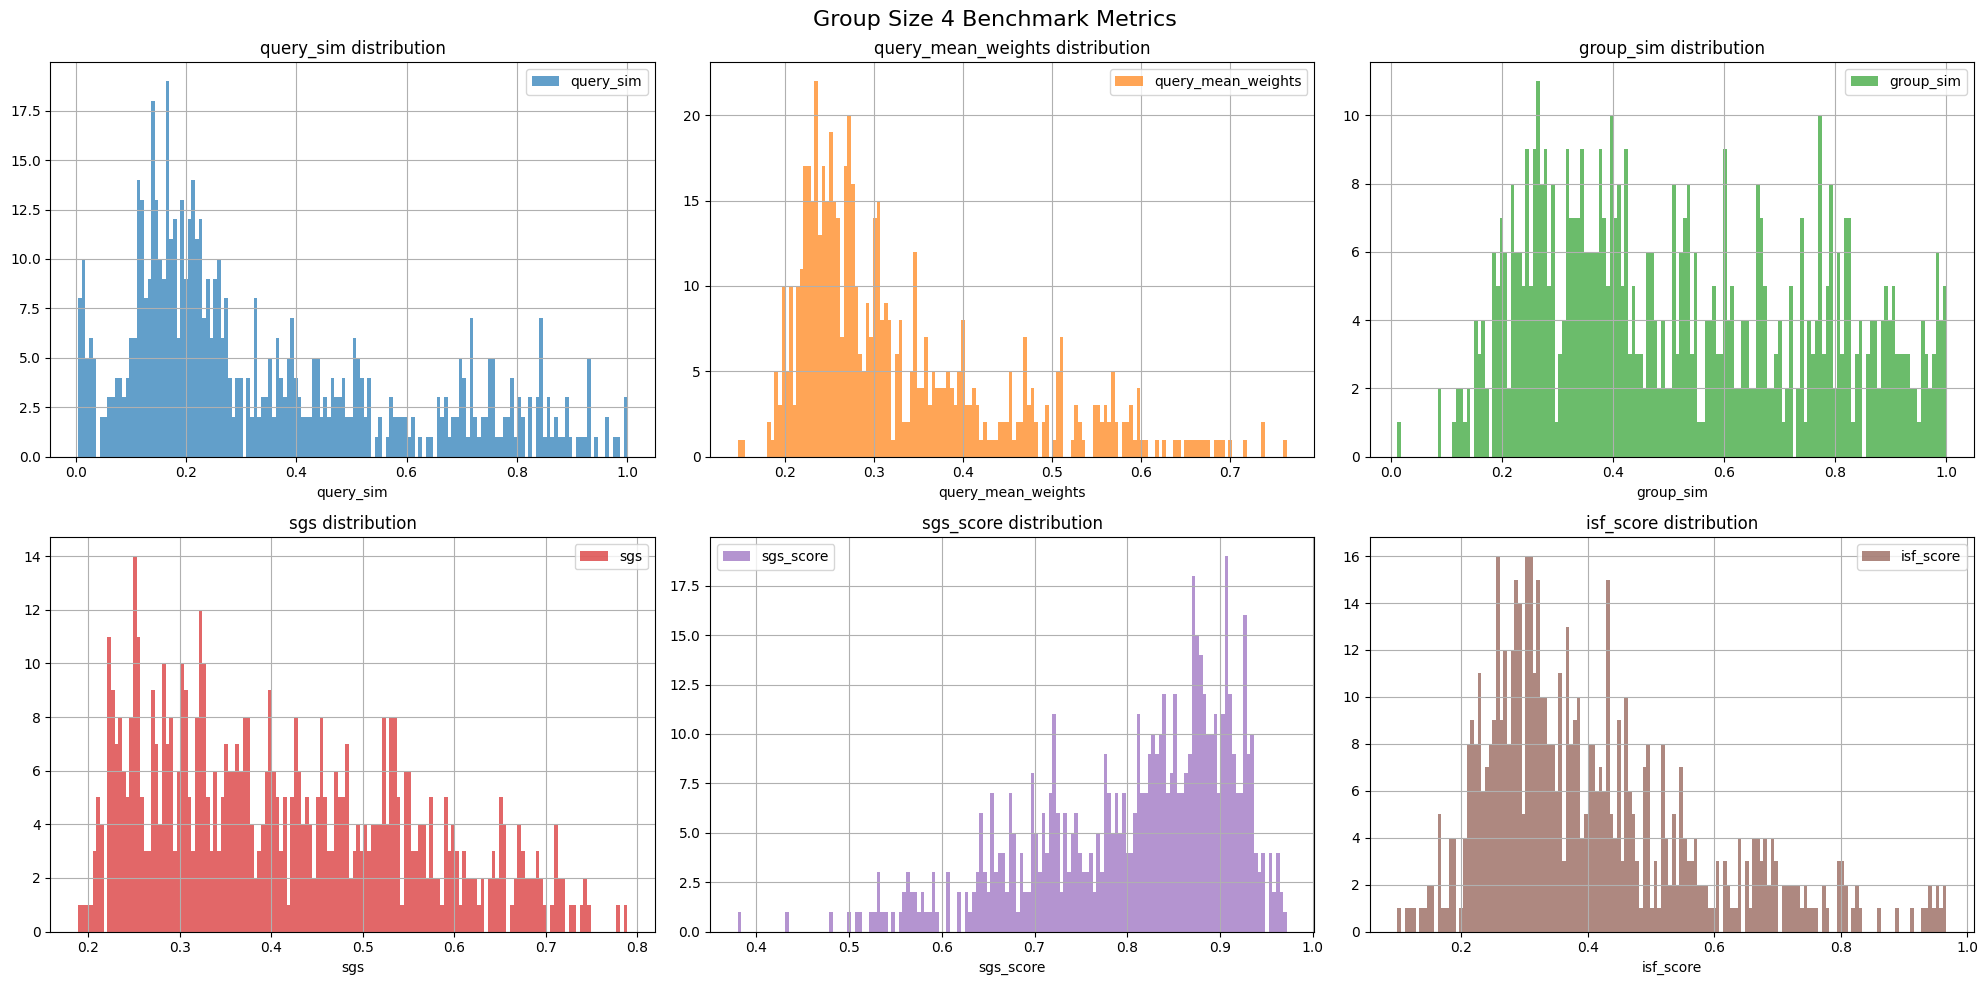

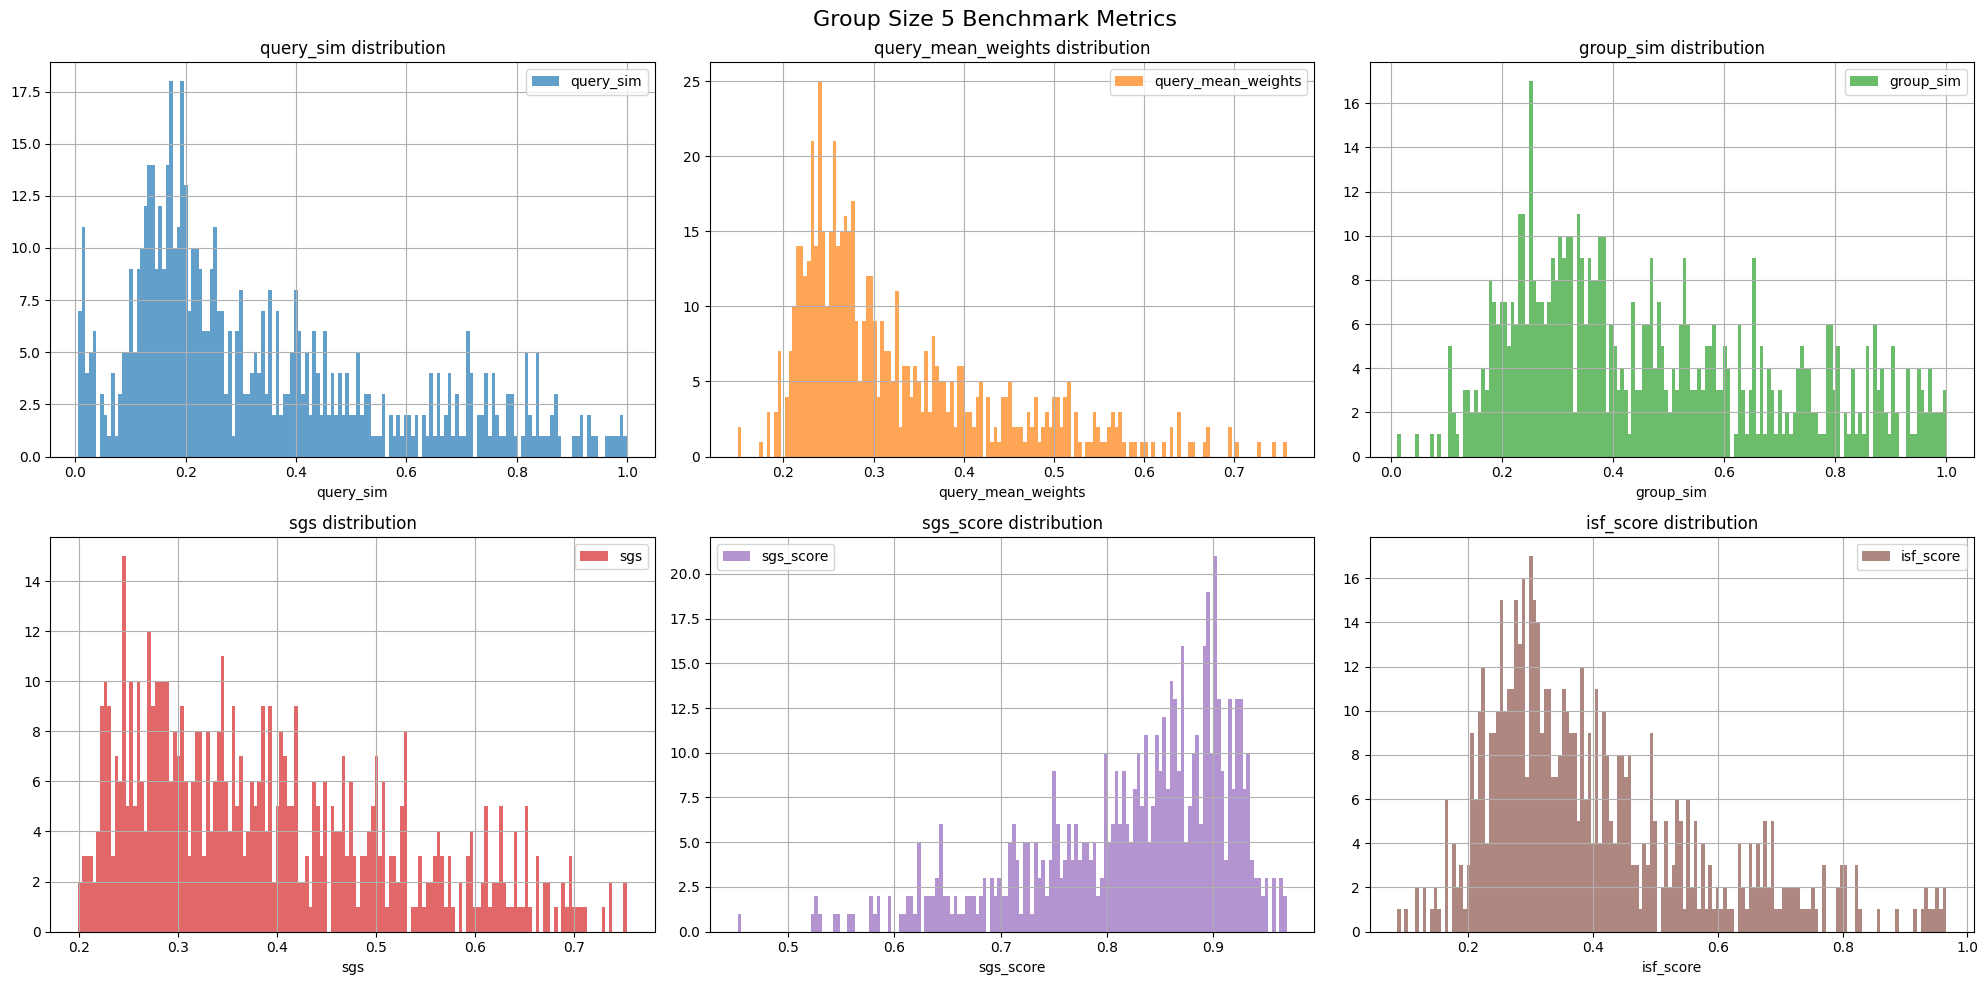

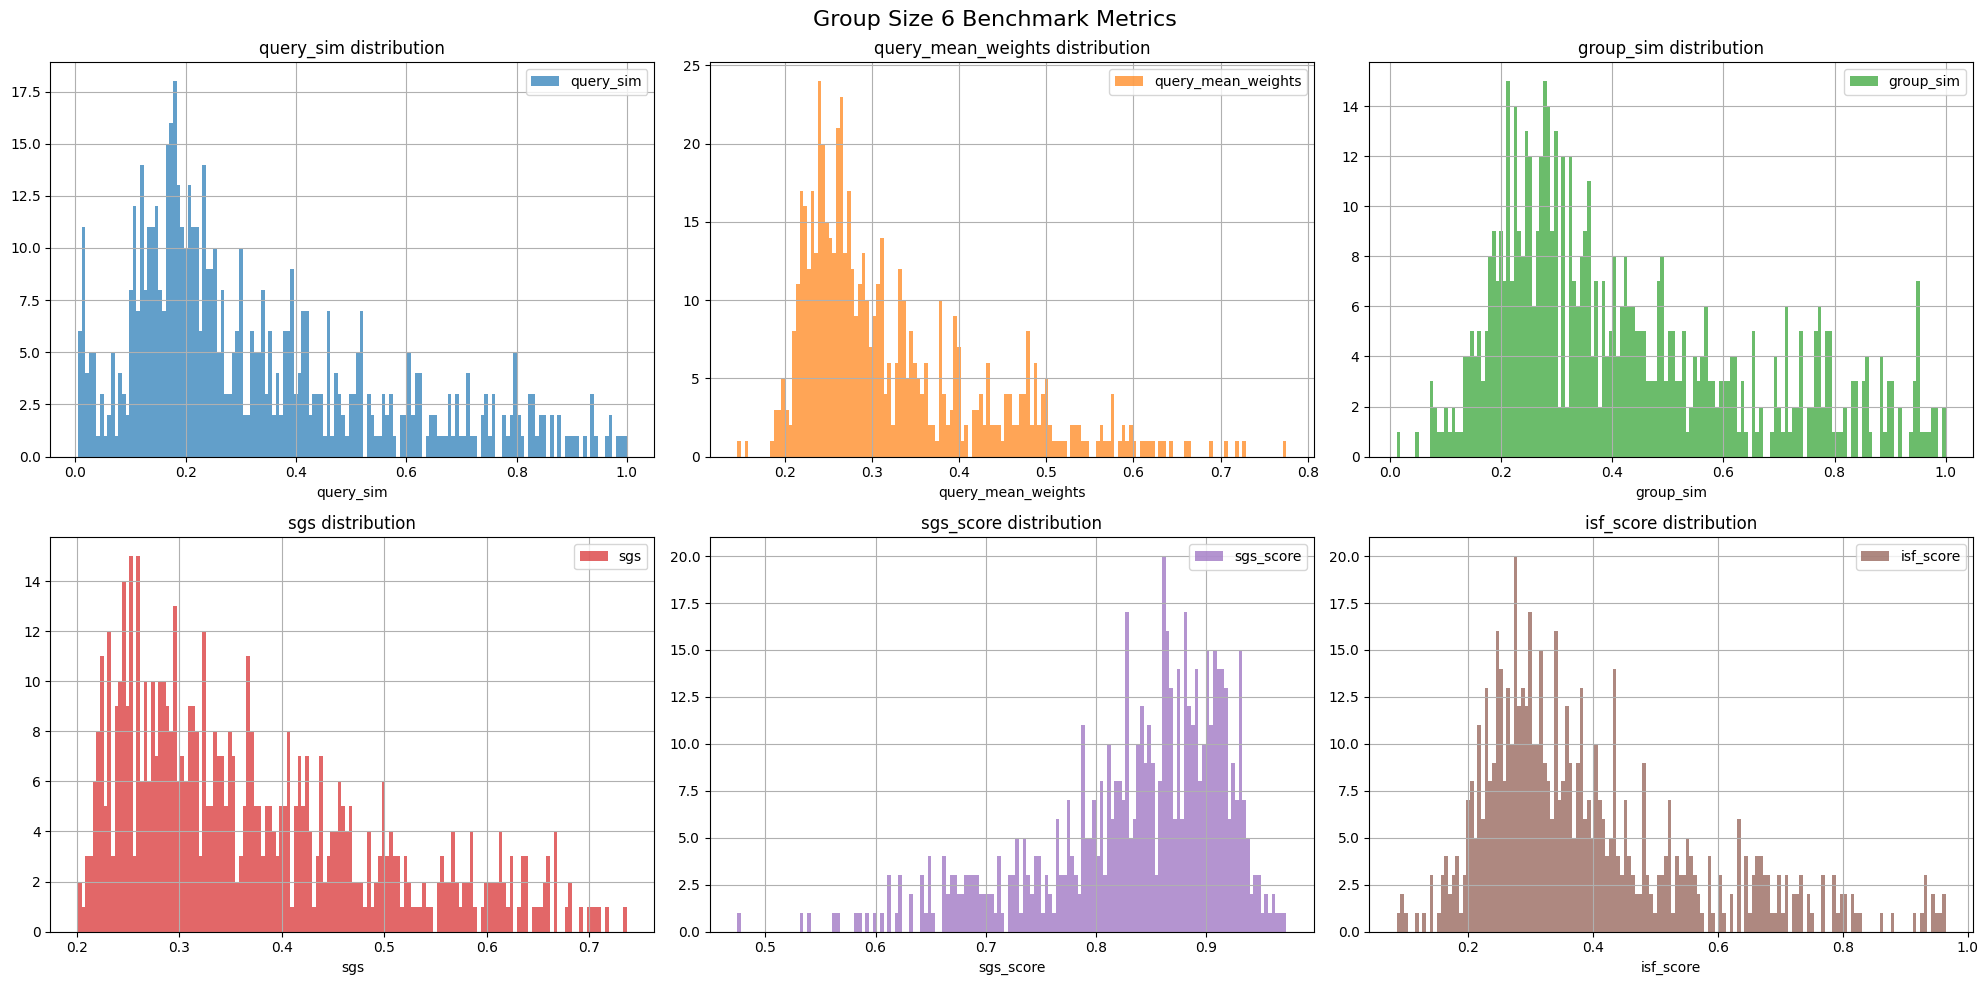

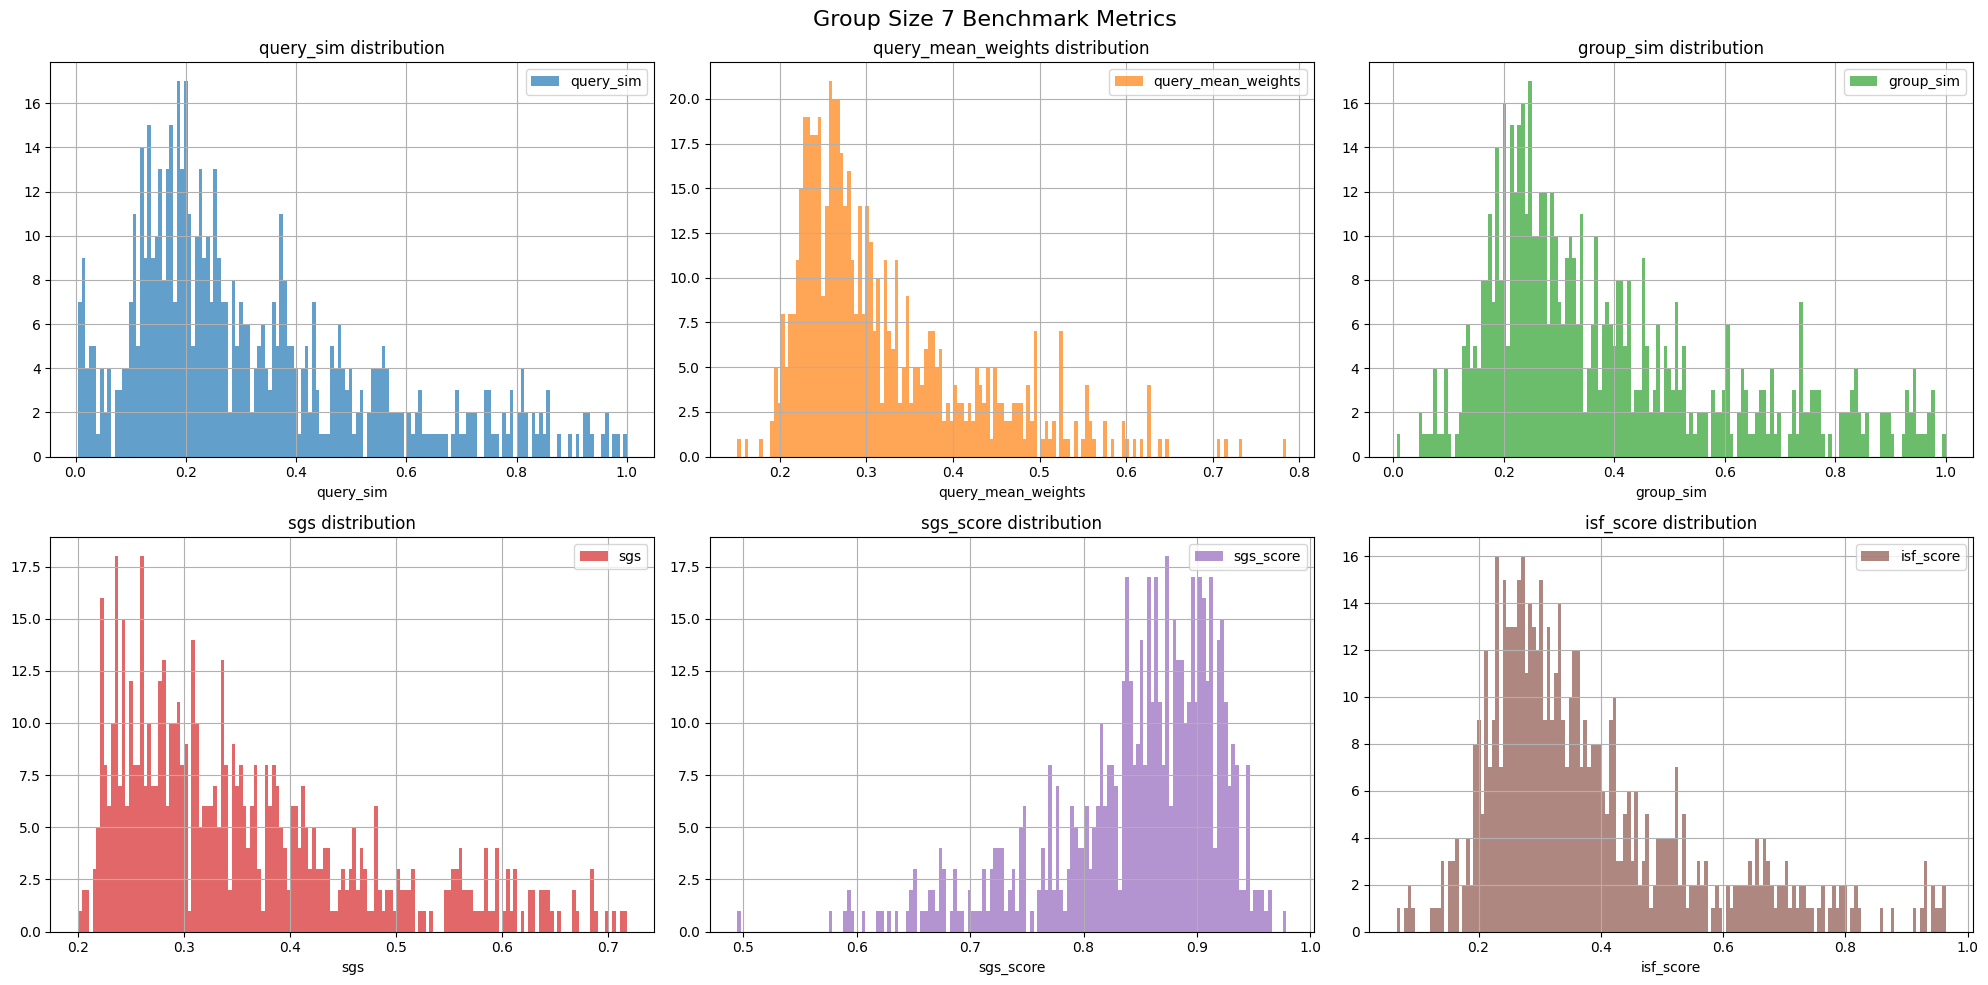

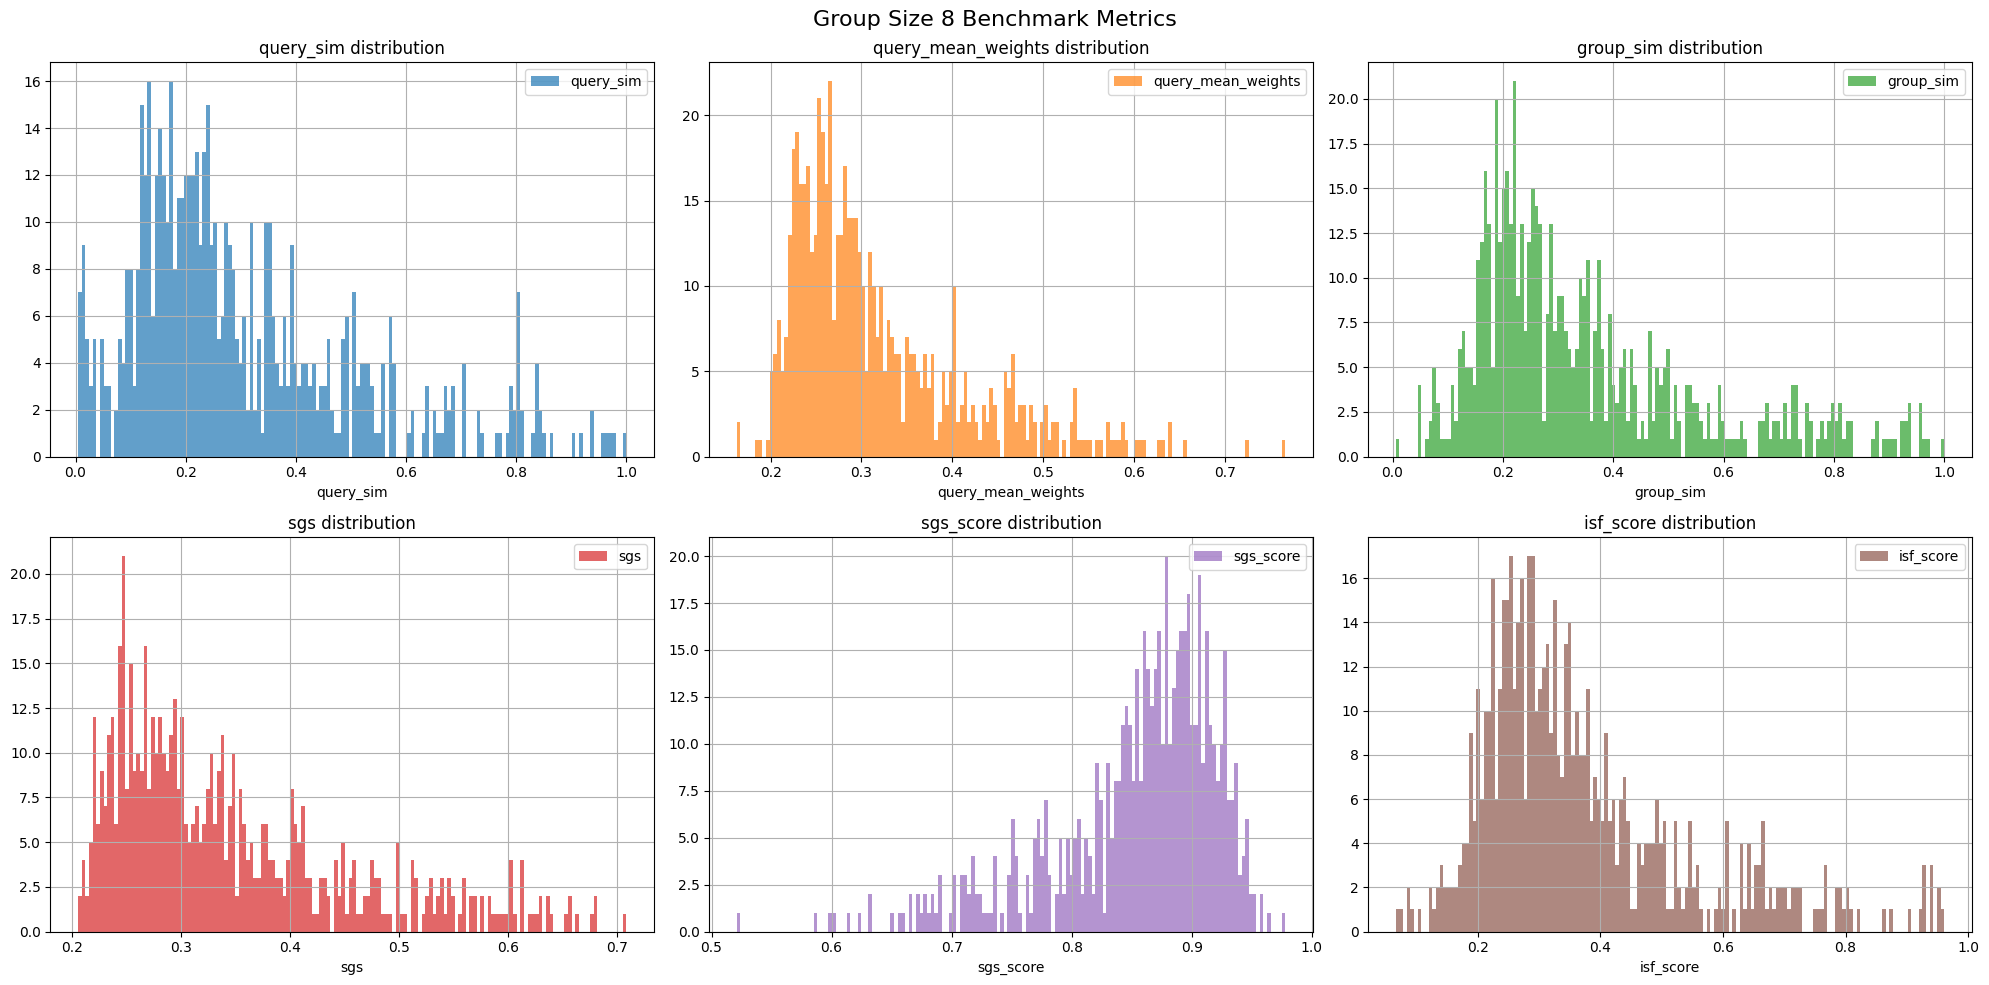

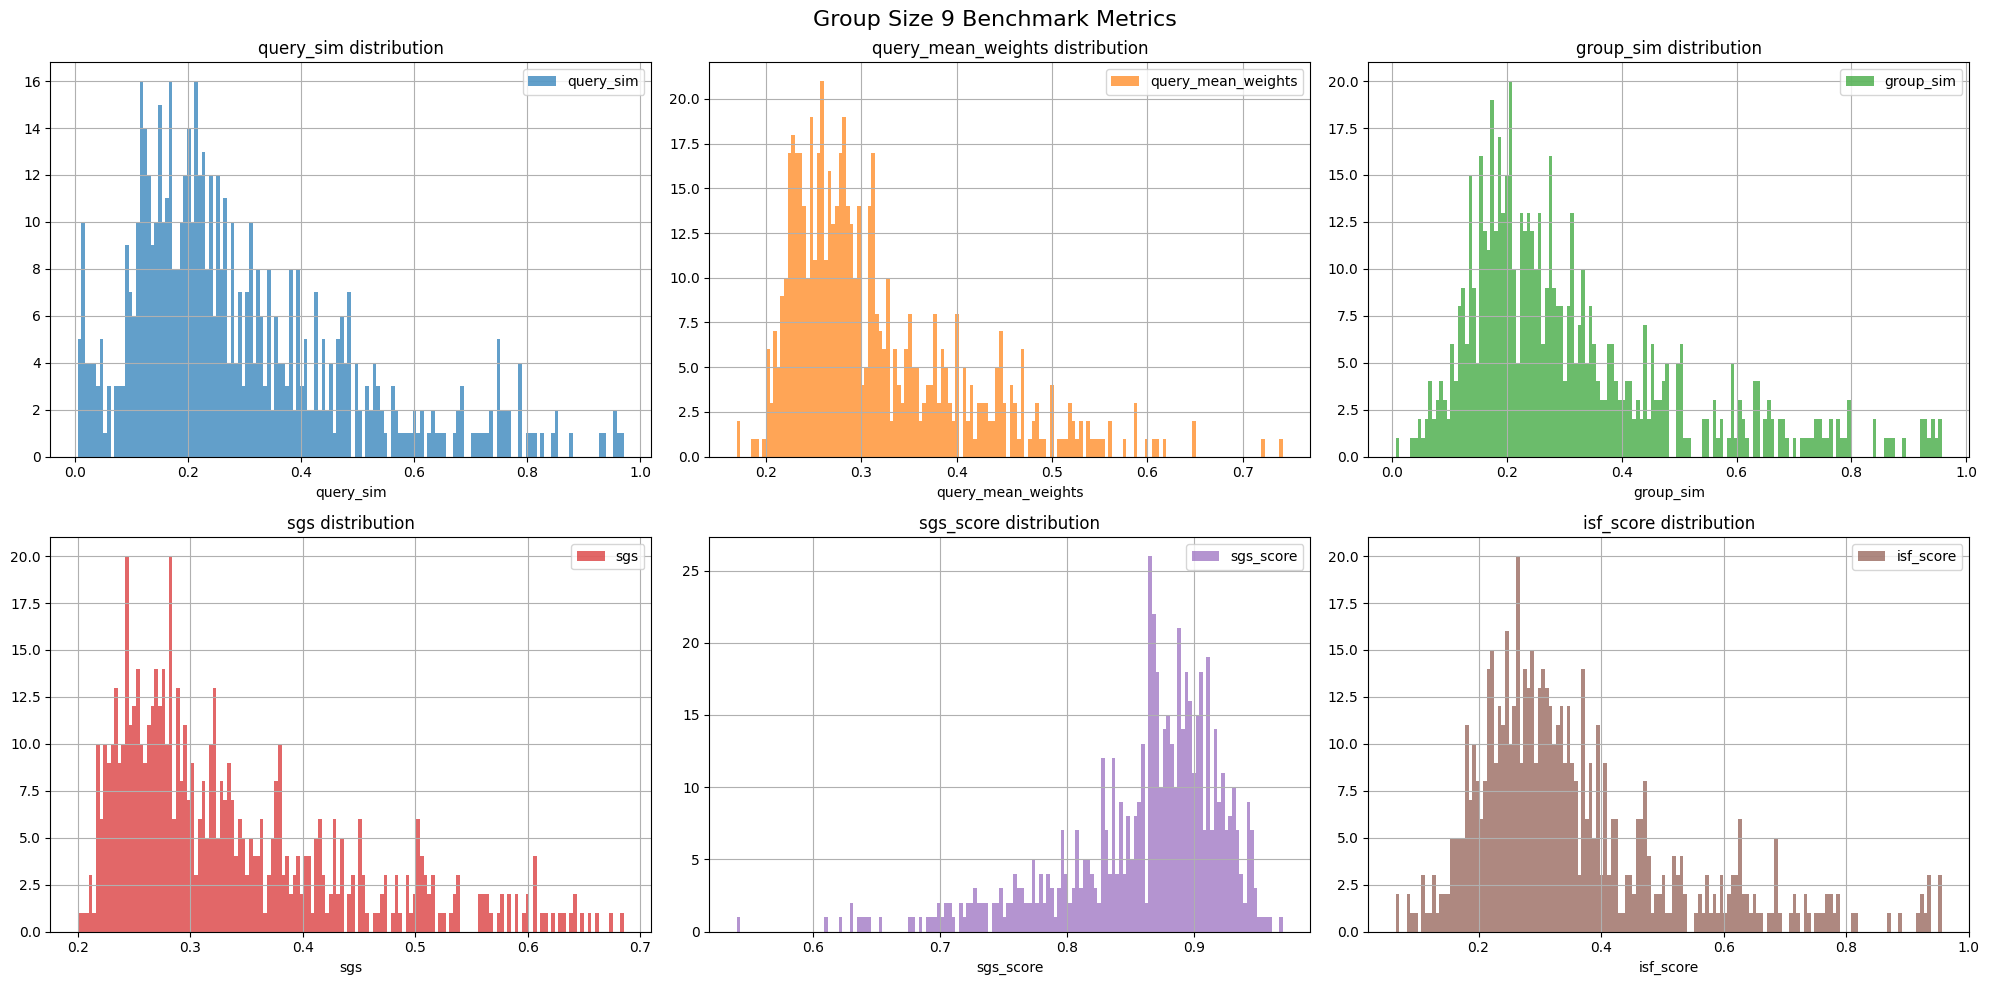

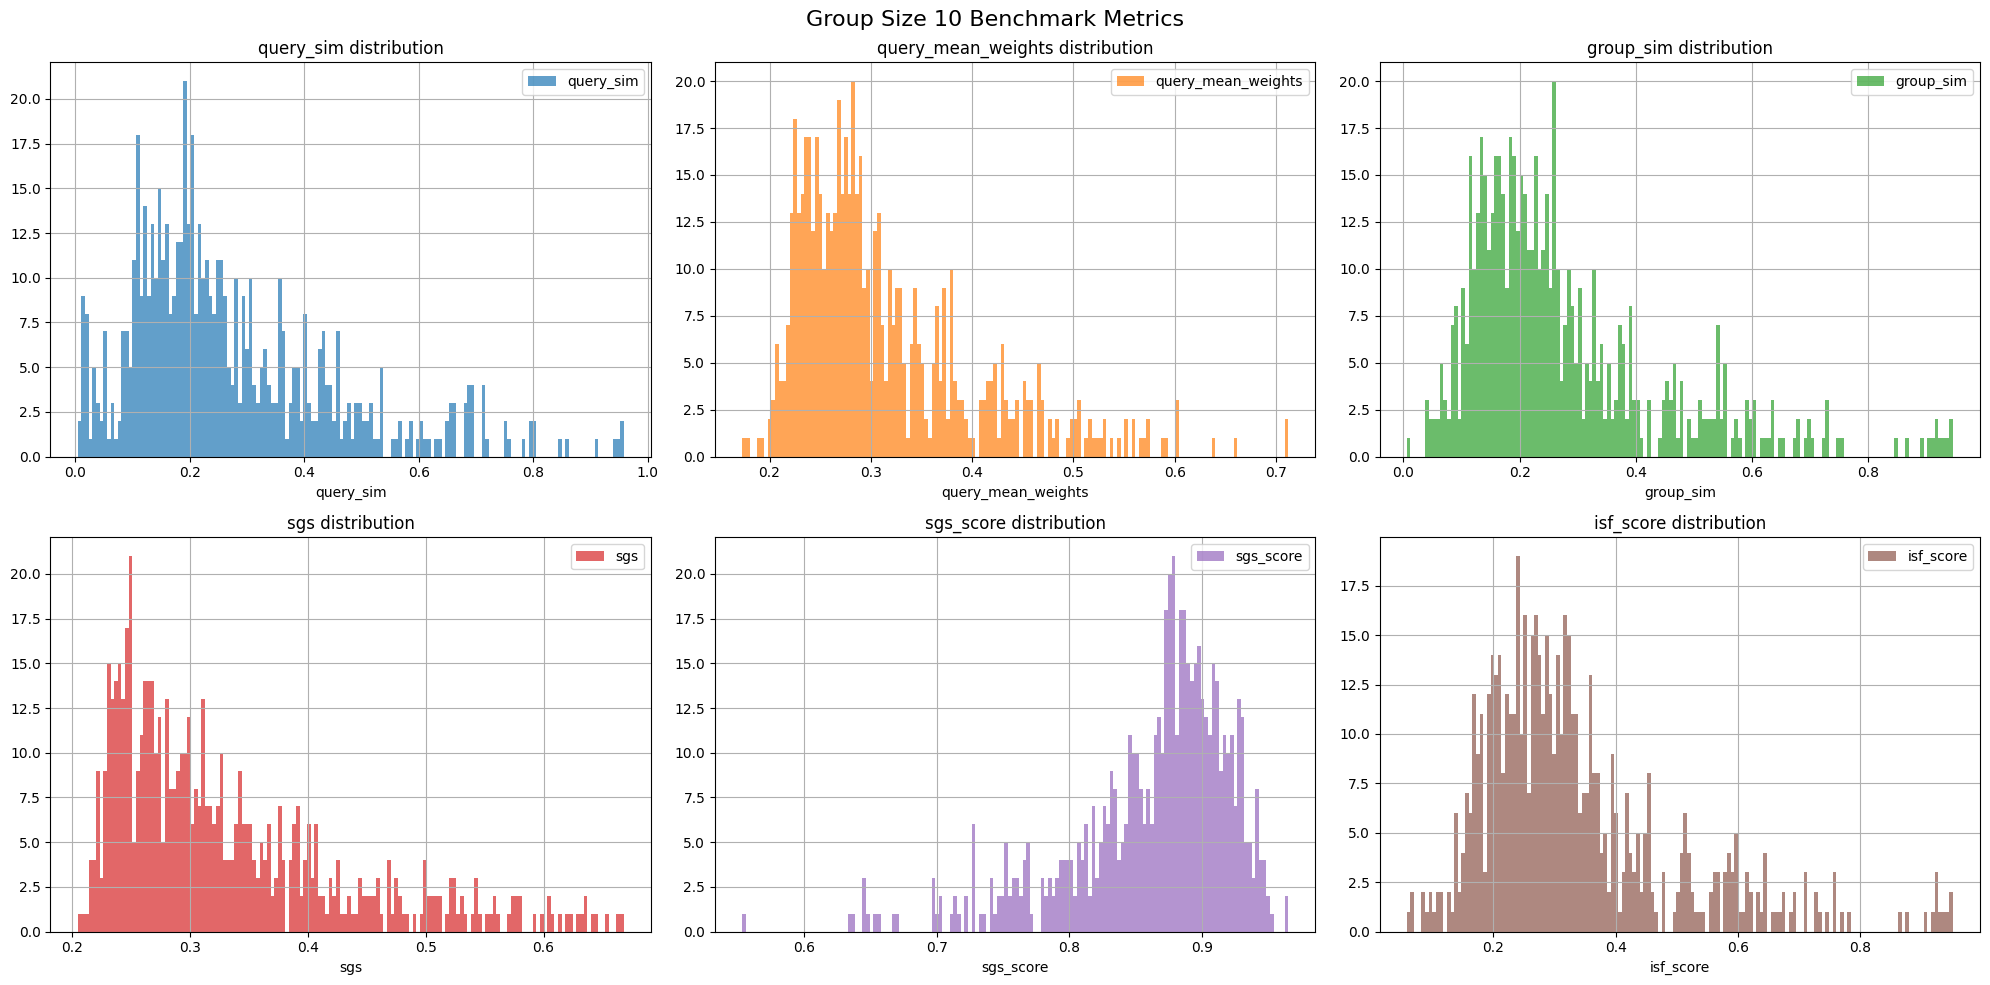

In [35]:
import matplotlib.pyplot as plt

for i, df in enumerate(all_dfs):
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2 rows, 3 columns for 6 plots
    fig.suptitle(f"Group Size {i + 2} Benchmark Metrics", fontsize=16)
    axes = axes.flatten()  # Flatten to make indexing easier

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    for i, column in enumerate(benchmark_columns):
        ax = axes[i]
        
        # Plot lines with different markers
        color = colors[i % len(colors)]
        ax.hist(df[column], bins=150, alpha=0.7, label=f"{column}", color=color)
        
        ax.set_xlabel(column)
        ax.grid(True)
        ax.set_title(f"{column} distribution")
        ax.legend()

    # Hide the last empty subplot
    #axes[7].set_visible(False)

    plt.tight_layout()
    plt.show()